In [1]:
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

import matplotlib.pyplot as pl
import pandas as pd
import pooch
import numpy as np

/Users/c.l.b.alexander/Documents/FAIR/fair_virtual_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
climate_response_df = pd.read_csv('../data/fair-calibrations/4xCO2_energy_balance_ebm3.csv')

In [3]:
climate_response_df#.loc[0, 'C1':'C3']

,model,run,gamma,C1,C2,C3,kappa1,kappa2,kappa3,epsilon,sigma_eta,sigma_xi,F_4xCO2
0,UKESM1-0-LL,r1i1p1f2,3.548407,2.9173,11.283175,73.248724,0.655766,2.597878,0.612934,1.133709,0.497439,0.439134,7.378788


In [4]:
f = FAIR()

In [5]:
scenarios = ['ssp245']
configs = ['UKESM1-0-LL']
species = ['BC', 'Aerosol-radiation interactions', 'Aerosol-cloud interactions']

In [6]:
f.define_time(1850, 2015, 1)
f.define_scenarios(scenarios)
f.define_configs(configs)
f.define_species(*read_properties(filename='../data/species_configs_properties_vanilla.csv', species=species))

In [7]:
f.allocate()

In [8]:
f.fill_from_rcmip()

In [9]:
fill(f.climate_configs['ocean_heat_capacity'], climate_response_df.loc[0, 'C1':'C3'])
fill(f.climate_configs['ocean_heat_transfer'], climate_response_df.loc[0, 'kappa1':'kappa3'])
fill(f.climate_configs['deep_ocean_efficacy'], climate_response_df.loc[0, 'epsilon'])
fill(f.climate_configs['gamma_autocorrelation'], climate_response_df.loc[0, 'gamma'])

In [10]:
initialise(f.forcing, 0)
initialise(f.temperature, 0)

In [11]:
f.fill_species_configs(filename='../data/species_configs_properties_vanilla.csv')

In [12]:
f.species_configs

<xarray.Dataset> Size: 1kB
Dimensions:                                   (config: 1, specie: 3, gasbox: 4)
Coordinates:
  * config                                    (config) <U11 44B 'UKESM1-0-LL'
  * specie                                    (specie) <U30 360B 'BC' ... 'Ae...
  * gasbox                                    (gasbox) int64 32B 0 1 2 3
Data variables: (12/31)
    tropospheric_adjustment                   (config, specie) float64 24B 0....
    forcing_efficacy                          (config, specie) float64 24B 1....
    forcing_temperature_feedback              (config, specie) float64 24B 0....
    forcing_scale                             (config, specie) float64 24B 1....
    partition_fraction                        (config, specie, gasbox) float64 96B ...
    unperturbed_lifetime                      (config, specie, gasbox) float64 96B ...
    ...                                        ...
    aci_shape                                 (config, specie) float64 24B 0....
    cl_atoms                                  (specie) float64 24B nan nan nan
    br_atoms                                  (specie) float64 24B nan nan nan
    fractional_release                        (config, specie) float64 24B na...
    ch4_lifetime_chemical_sensitivity         (config, specie) float64 24B 0....
    lifetime_temperature_sensitivity          (config) float64 8B 0.0

In [13]:
rcmip_emissions_file = pooch.retrieve(
    url="doi:10.5281/zenodo.4589756/rcmip-emissions-annual-means-v5-1-0.csv",
    known_hash="md5:4044106f55ca65b094670e7577eaf9b3",
)
emis_df = pd.read_csv(rcmip_emissions_file)

In [14]:
bc = emis_df.loc[(emis_df['Scenario']=='historical')&(emis_df['Variable']=='Emissions|BC')&(emis_df['Region']=='World'),'1750':'2014'].values.squeeze()

In [15]:
# 1850 baselines
f.species_configs['baseline_emissions'].loc[dict(specie='BC')] = 2.57112447874271

In [16]:
# aerosol forcing response - from notebook 01, last cell
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='BC')] = 5.29745549e-02
f.species_configs['aci_scale'].loc[dict(config='UKESM1-0-LL')] = -1.56516693e+05
f.species_configs['aci_shape'].loc[dict(specie='BC')] = 1.33602296e-08

In [17]:
# UKESM calibrations
f.species_configs['aci_scale']

<xarray.DataArray 'aci_scale' (config: 1)> Size: 8B
array([-156516.693])
Coordinates:
  * config   (config) <U11 44B 'UKESM1-0-LL'

In [18]:
f.run()

Running 1 projections in parallel: 100%|██████████| 165/165 [00:00<00:00, 14463.72timesteps/s]


In [19]:
# Target +0.38
f.forcing.loc[dict(specie='Aerosol-radiation interactions', config='UKESM1-0-LL', scenario='ssp245')].values[-1]

np.float64(0.3800000003099107)

In [20]:
# Target -0.01
f.forcing.loc[dict(specie='Aerosol-cloud interactions', config='UKESM1-0-LL', scenario='ssp245')].values[-1]

np.float64(-0.014999985177265845)

In [21]:
# Target +0.37
(
    f.forcing.loc[dict(specie='Aerosol-cloud interactions', config='UKESM1-0-LL', scenario='ssp245')].values[-1] +
    f.forcing.loc[dict(specie='Aerosol-radiation interactions', config='UKESM1-0-LL', scenario='ssp245')].values[-1]
)

np.float64(0.36500001513264485)

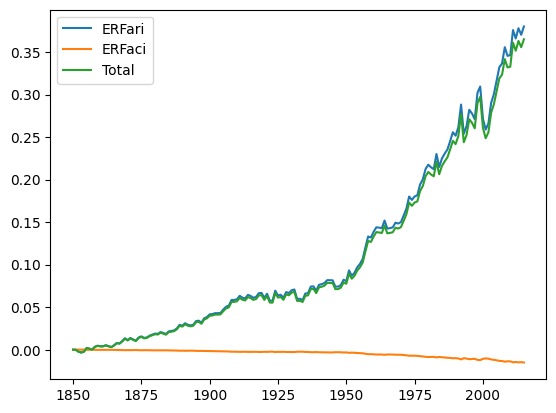

In [22]:
pl.plot(
    f.timebounds,
    f.forcing.loc[dict(specie='Aerosol-radiation interactions', config='UKESM1-0-LL', scenario='ssp245')],
    label='ERFari'
)
pl.plot(
    f.timebounds,
    f.forcing.loc[dict(specie='Aerosol-cloud interactions', config='UKESM1-0-LL', scenario='ssp245')],
    label='ERFaci'
)
pl.plot(
    f.timebounds,
    f.forcing.loc[dict(specie='Aerosol-radiation interactions', config='UKESM1-0-LL', scenario='ssp245')] + 
    f.forcing.loc[dict(specie='Aerosol-cloud interactions', config='UKESM1-0-LL', scenario='ssp245')],
    label='Total'
)
pl.legend()